# Optimize performance and VRAM Usage

## Set the baseline

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: total: 32.4 s
Wall time: 1min 8s


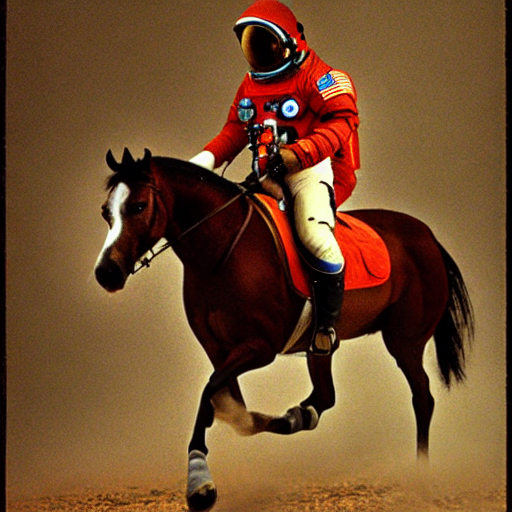

In [1]:
%%time
# baseline
# VRAM: 8.4G
# inference speed: 7.51/it with RTX 3090
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
).to("cuda:0")

# generate an image
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

## float16 vs bfloat16

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

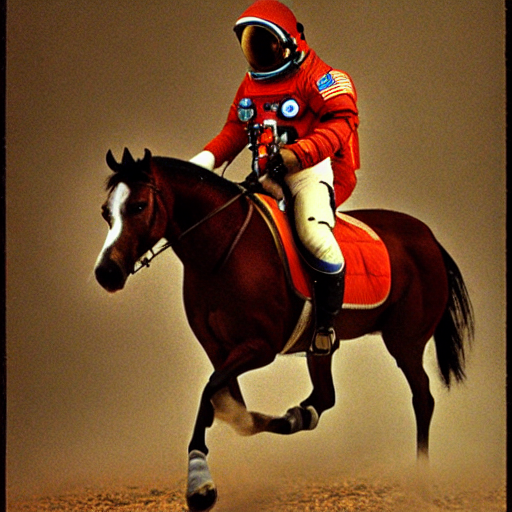

In [2]:
# Load up model with torch.float16
# VRAM: 4.7G
# inference speed: 19.1/it with RTX 3090
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

# generate an image
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

In [3]:
# Load up model with torch.bfloat16
# VRAM: 4.8G
# inference speed: 19.24/it with RTX 3090
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.bfloat16
).to("cuda:0")

# generate an image
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: cutlassF: no kernel found to launch!

## Sliced Attention

In [4]:
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

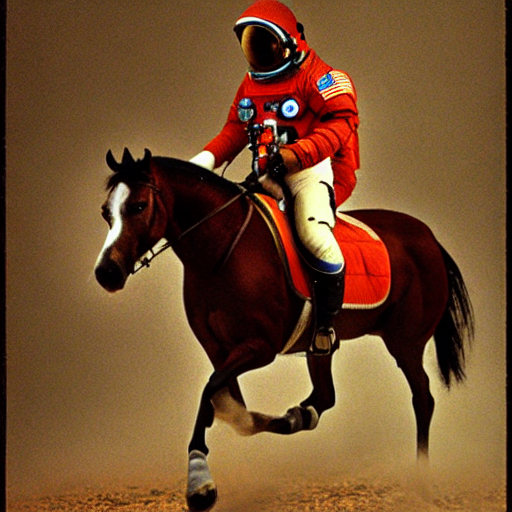

In [5]:
# generate an image
text2img_pipe.enable_attention_slicing()
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
    , num_images_per_prompt = 8
).images[0]
image

# without slicing VRAM: 12.1
# with slicing VRAM 12.1

## VAE Tiling

In [6]:
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

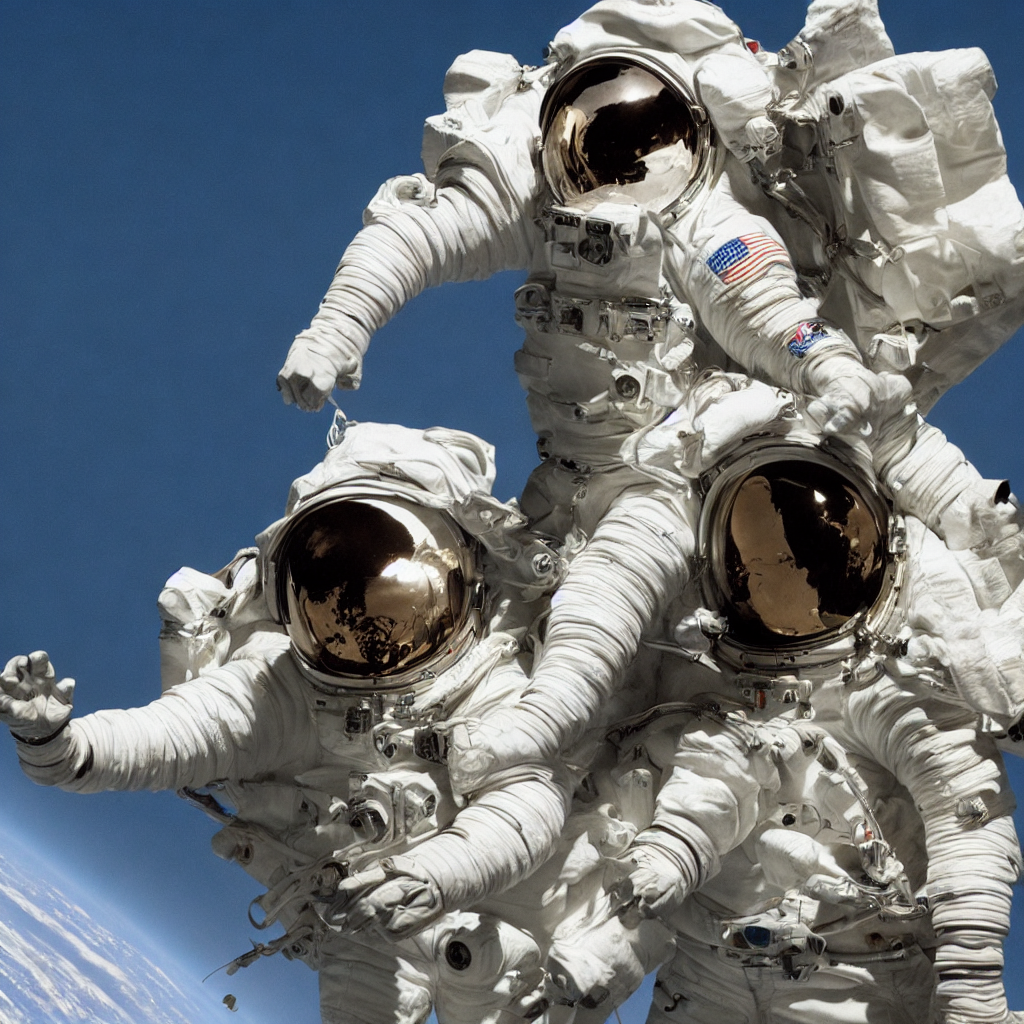

In [7]:
# generate an image without vae tiling
# VRAM: 7.6G
# Speed: 3.67
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
    , width = 1024
    , height= 1024
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

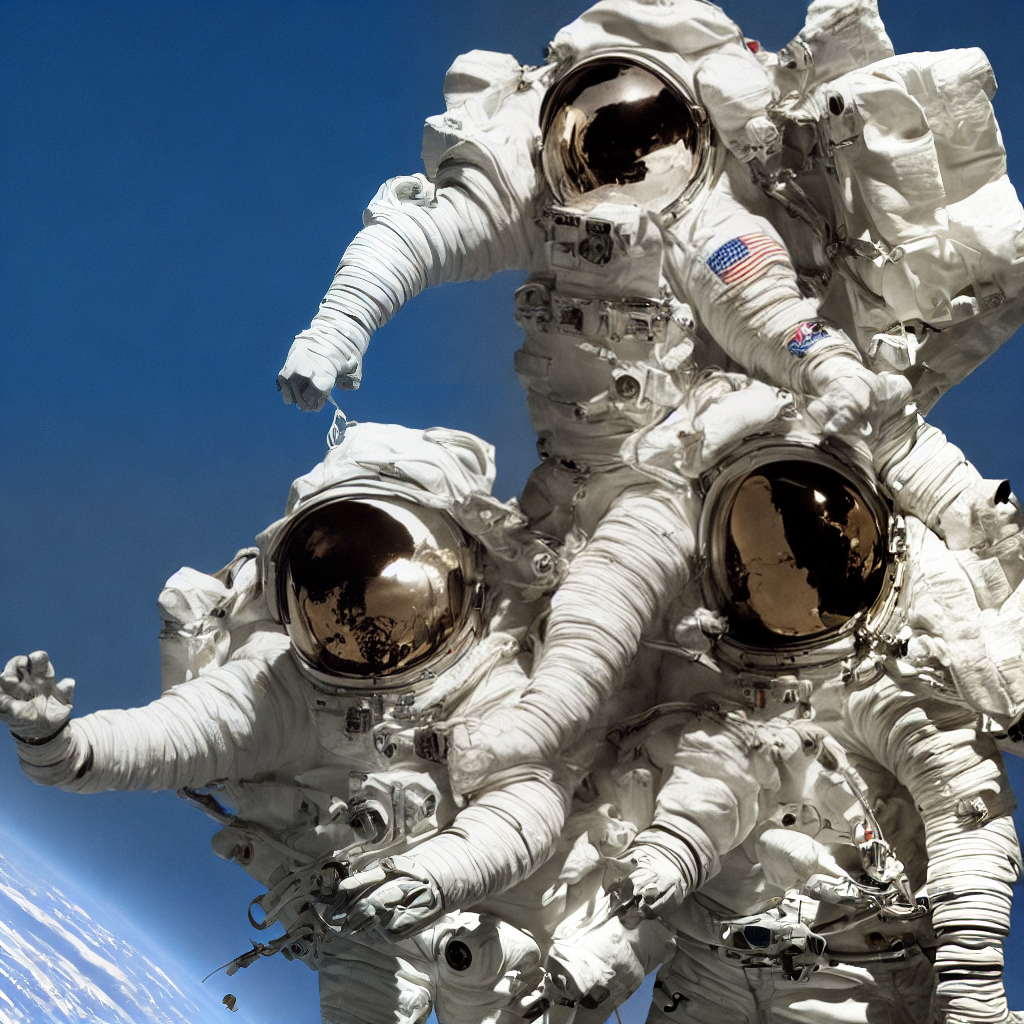

In [8]:
# generate an image with vae tiling
# VRAM: 5.1G
# Speed: 3.67
text2img_pipe.enable_vae_tiling()
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
    , width = 1024
    , height= 1024
).images[0]
image

## Using Xformers

In [9]:
text2img_pipe.enable_xformers_memory_efficient_attention()  # < Enable xformers
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

ModuleNotFoundError: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers

## Sequential CPU offload

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

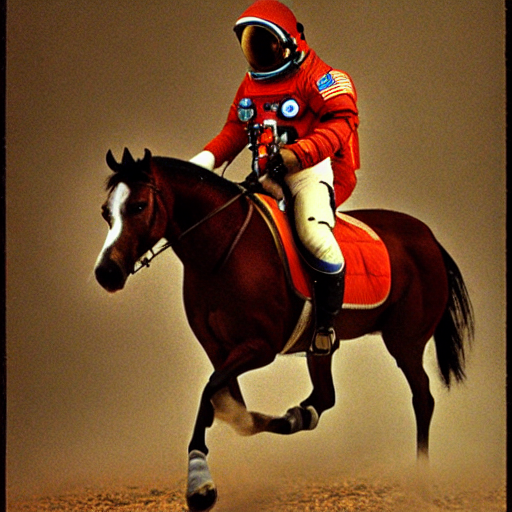

In [10]:
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

# generate an image
text2img_pipe.enable_sequential_cpu_offload()
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

20
tensor(999., device='cuda:0')
tensor(946.4211, device='cuda:0')
tensor(893.8421, device='cuda:0')
tensor(841.2632, device='cuda:0')
tensor(788.6842, device='cuda:0')
tensor(736.1053, device='cuda:0')
tensor(683.5263, device='cuda:0')
tensor(630.9474, device='cuda:0')
tensor(578.3684, device='cuda:0')
tensor(525.7895, device='cuda:0')
tensor(473.2105, device='cuda:0')
tensor(420.6316, device='cuda:0')
tensor(368.0526, device='cuda:0')
tensor(315.4737, device='cuda:0')
tensor(262.8947, device='cuda:0')
tensor(210.3158, device='cuda:0')
tensor(157.7368, device='cuda:0')
tensor(105.1579, device='cuda:0')
tensor(52.5789, device='cuda:0')
tensor(0., device='cuda:0')
0 tensor(999., device='cuda:0')
1 tensor(946.4211, device='cuda:0')
tensor(893.8421, device='cuda:0')
3 tensor(841.2632, device='cuda:0')
tensor(788.6842, device='cuda:0')
5 tensor(736.1053, device='cuda:0')
tensor(683.5263, device='cuda:0')
7 tensor(630.9474, device='cuda:0')
8 tensor(578.3684, device='cuda:0')
tensor(525.789

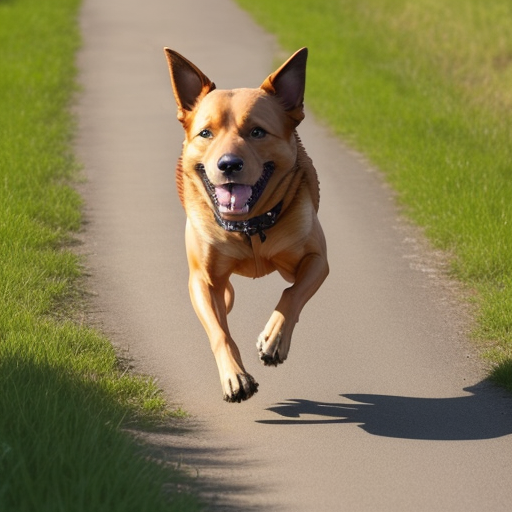

In [11]:
# custome sequential CPU offload
import torch
from diffusers import AutoencoderKL

def load_to_vram(model):
    model.to("cuda:0")
    
def offload_to_cpu(model):
    model.to("cpu")
    torch.cuda.empty_cache()    

# Initialize VAE model
vae_model = AutoencoderKL.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "vae"
    , torch_dtype = torch.float16
)

#input_prompt = "a running dog, playing a football"
input_prompt = "a running dog"

# input tokenizer and clip embedding model
from transformers import CLIPTokenizer,CLIPTextModel
import torch

# initialize tokenizer
clip_tokenizer = CLIPTokenizer.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "tokenizer"
    , dtype = torch.float16
)
input_tokens = clip_tokenizer(
    input_prompt
    , return_tensors="pt"
)["input_ids"]
input_tokens

# initialize CLIP text encoder model
clip_text_encoder = CLIPTextModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder = "text_encoder"
    , torch_dtype =torch.float16
).to("cuda:0")

# encode token ids to embeddings
with torch.no_grad(): 
    prompt_embeds = clip_text_encoder(
        input_tokens.to("cuda")
    )[0]
    
# prepare neg prompt embeddings
uncond_tokens = "blur"

# get the prompt embedding length
max_length = prompt_embeds.shape[1]

# generate negtive prompt tokens with the same lenght of prompt
uncond_input_tokens = clip_tokenizer(
    uncond_tokens
    , padding = "max_length"
    , max_length = max_length
    , truncation = True
    , return_tensors = "pt"
)["input_ids"]

# generate the negative embeddings
with torch.no_grad(): 
    negative_prompt_embeds = clip_text_encoder(
        uncond_input_tokens.to("cuda")
    )[0]

# concat prompt and neg prompt embeddings
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

# offload VAE to cpu
offload_to_cpu(clip_text_encoder)

# Euler scheduelr
from diffusers import EulerDiscreteScheduler as Euler

# initialize scheduler from a pretrained checkpoint
scheduler = Euler.from_pretrained(
    #"runwayml/stable-diffusion-v1-5"
    "stablediffusionapi/deliberate-v2"
    , subfolder = "scheduler"
    , torch_dtype = torch.float16
)

inference_steps = 20
scheduler.set_timesteps(inference_steps, device = "cuda")

timesteps = scheduler.timesteps
print(len(timesteps))
for t in timesteps:
    print(t)
    
# Initialize Stabel Diffusion UNet
import torch
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , subfolder ="unet"
    , torch_dtype = torch.float16
)

load_to_vram(unet)

# prepare latents
shape = torch.Size([1, 4, 64, 64])
device = "cuda"
noise_tensor = torch.randn(
    shape
    , generator = None
    , dtype     = torch.float16
).to("cuda")

# scale the initial noise by the standard deviation required by the scheduler
latents = noise_tensor*scheduler.init_noise_sigma

# inference
guidance_scale = 7.5
latents_sd = torch.clone(latents)
for i,t in enumerate(timesteps):
    print(i,t)
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents_sd] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input
            , t
            , encoder_hidden_states=prompt_embeds
            , return_dict = False
        )[0]
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents_sd = scheduler.step(noise_pred, t, latents_sd, return_dict=False)[0]
    
# offload unet to cpu
offload_to_cpu(unet)
    
# recover image from latent
import numpy as np
from PIL import Image

# load up vae
load_to_vram(vae_model)

def latent_to_img(latents_input):
    # decode image
    with torch.no_grad():
        decode_image = vae_model.decode(
            latents_input
            , return_dict = False
        )[0][0]

    decode_image =  (decode_image / 2 + 0.5).clamp(0, 1)

    # move latent data from cuda to cpu
    decode_image = decode_image.to("cpu")

    # convert torch tensor to numpy array
    numpy_img = decode_image.detach().numpy()

    # covert image array from (width, height, channel) to (channel, width, height)
    numpy_img_t = numpy_img.transpose(1,2,0)

    # map image data to 0, 255, and convert to to int number
    numpy_img_t_01_255 = (numpy_img_t*255).round().astype("uint8")

    # shape the pillow image object from the numpy array
    return Image.fromarray(numpy_img_t_01_255)
    
latents_2 = (1 / 0.18215) * latents_sd
pil_img = latent_to_img(latents_2)

offload_to_cpu(vae_model)

pil_img

## Whole model offloading

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

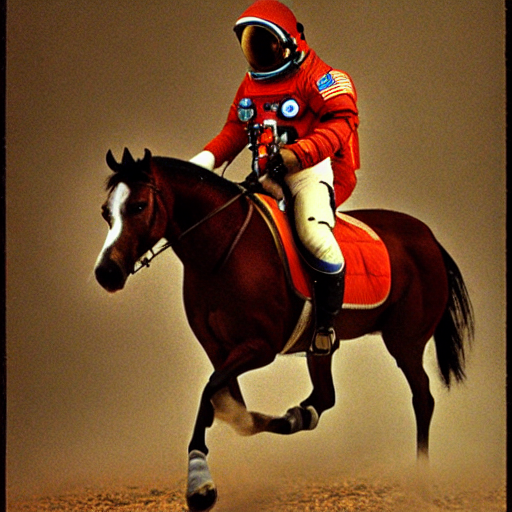

In [12]:
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
)

# generate an image
text2img_pipe.enable_model_cpu_offload()
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image

## Using ToMe

In [13]:
!pip install tomesd

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

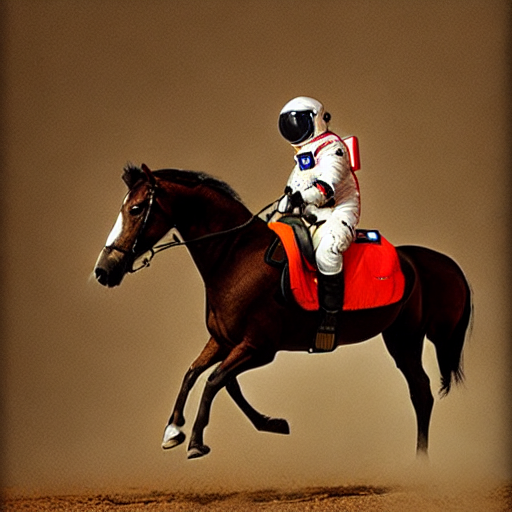

In [1]:
import torch
from diffusers import StableDiffusionPipeline
import tomesd

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

tomesd.apply_patch(text2img_pipe, ratio=0.5)
# generate an image
prompt = "high resolution, a photograph of an astronaut riding a horse"
image = text2img_pipe(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
image